## 特征构建
1. 检查数据集；
2. 填充分类特征；
3. 编码分类变量；
4. 扩展数值特征；
5. 针对文本的特征构建。

### 4.1 检查数据集

In [1]:
# 导入Pandas
import pandas as pd

In [2]:
X = pd.DataFrame({
    'city': ['tokyo', None, 'london', 'seattle', 'san francisco', 'tokyo'],
    'boolean': ['yes', 'no', None, 'no', 'no', 'yes'],
    'ordinal_column': ['somewhat like', 'like', 'somewhat like', 'like', 'somewhat like', 'dislike'],
    'quantitative_column': [1, 11, -.5, 10, None, 20]
})

In [3]:
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


1. boolean（布尔值）：此列是二元分类数据（是/否），定类等级；
2. city（城市）：此列是分类数据，也是定类等级；
3. ordinal_column（顺序列）：此列是顺序数据，定序等级；
4. quantitative_column（定量列）：此列是整数，定比等级（是否存在绝对零点）。

In [4]:
# 查看缺失值
X.isnull().sum()

city                   1
boolean                1
ordinal_column         0
quantitative_column    1
dtype: int64

In [5]:
# 对于数值型数据，可以通过计算均值的方法填充缺失值；对于分类数据，计算最常见的类用于填充。
# 寻找city列中最常见的元素
X['city'].value_counts().index[0]

'tokyo'

In [6]:
# 用最常见的值填充city列
X['city'].fillna(X['city'].value_counts().index[0])

0            tokyo
1            tokyo
2           london
3          seattle
4    san francisco
5            tokyo
Name: city, dtype: object

## 4.2 填充分类特征
### 4.2.1 自定义填充器
流水线的中间步骤只能是转换，意味着必须实现fit和transform方法。  
流水线的目的是将几个可以交叉验证的步骤组装在一起，并设置不同的参数。  
下面开始编写自定义分类填充器：

### 4.2.2 自定义分类填充器

In [7]:
from sklearn.base import TransformerMixin

In [8]:
class CustomCategoryImputer(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
            
    # 不需要fit什么东西，直接返回fit self
    def fit(self, *_):
        return self

In [9]:
# 在列上应用自定义分类填充器：
cci = CustomCategoryImputer(cols=['city', 'boolean'])

In [10]:
cci.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


#### 4.2.3 自定义定量填充器
定量列还有缺失值，我们再来自定义一个

In [11]:
from sklearn.preprocessing import Imputer

In [12]:
class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
        
    def transform(self, df):
        X = df.copy()
        impute = Imputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
            
    # 不需要fit什么东西，直接返回fit self
    def fit(self, *_):
        return self

In [13]:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'], strategy='mean')

In [14]:
cqi.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


In [15]:
# 可以不使用fit_transform拟合转换，而是把它们放在流水线中
# 从sklearn导入Pipeline
from sklearn.pipeline import Pipeline

In [16]:
# 导入自定义填充器
imputer = Pipeline([('quant', cqi), ('category', cci)])
imputer.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


## 4.3 编码分类变量
任何机器学习算法，需要的输入特征都必须是数值，有几种办法可以将分类数据转换为数值数据：

#### 4.3.1 定类等级的编码
定类等级编码的主要方法是将分类数据转换为虚拟变量（dummy variable），有两种方法：
1. 用Pandas自动找到分类变量并进行编码；
2. 创建自定义虚拟变量编码器，在流水线工作。

In [17]:
# 1. 用Pandas自动找到分类变量并进行编码
pd.get_dummies(X, columns=['city', 'boolean'], prefix_sep='__')

,ordinal_column,quantitative_column,city__london,city__san francisco,city__seattle,city__tokyo,boolean__no,boolean__yes
0,somewhat like,1.0,0,0,0,1,0,1
1,like,11.0,0,0,0,0,1,0
2,somewhat like,-0.5,1,0,0,0,0,0
3,like,10.0,0,0,1,0,1,0
4,somewhat like,NaN,0,1,0,0,1,0
5,dislike,20.0,0,0,0,1,0,1


In [18]:
# 2. 创建自定义虚拟变量编码器
class CustomDummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cols)
    
    def fit(self, *_):
        return self

In [19]:
cd = CustomDummifier(cols=['boolean', 'city'])

In [20]:
cd.fit_transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,somewhat like,1.0,0,1,0,0,0,1
1,like,11.0,1,0,0,0,0,0
2,somewhat like,-0.5,0,0,1,0,0,0
3,like,10.0,1,0,0,0,1,0
4,somewhat like,NaN,1,0,0,1,0,0
5,dislike,20.0,0,1,0,0,0,1


#### 4.3.2 定序等级的编码
定序等级，由于数据的顺序有意义，使用虚拟变量是没有意义的。为了保持顺序，我们使用**标签编码器**。  
**标签编码器**是指，顺序数据的每个标签都会有一个相关的值。在我们的例子中，这意味着顺序列的值（dislike, somewhat like, like）用（0, 1, 2）表示。

In [21]:
# 创建一个列表，顺序数据对应于列表索引
ordering = ['dislike', 'somewhat like', 'like']

In [22]:
# 将ordering映射到顺序列
X['ordinal_column'].map(lambda x: ordering.index(x))

0    1
1    2
2    1
3    2
4    1
5    0
Name: ordinal_column, dtype: int64

In [23]:
# 还是将自定义标签编码器放进流水线：
class CustomEncoder(TransformerMixin):
    def __init__(self, col, ordering=None):
        self.ordering = ordering
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda x: self.ordering.index(x))
        return X
    
    def fit(self, *_):
        return self

In [24]:
ce = CustomEncoder(col='ordinal_column', ordering=['dislike', 'somewhat like', 'like'])
ce.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,1,1.0
1,None,no,2,11.0
2,london,None,1,-0.5
3,seattle,no,2,10.0
4,san francisco,no,1,NaN
5,tokyo,yes,0,20.0


#### 4.3.3 将连续特征分箱

In [25]:
# 默认的类别名就是分箱
pd.cut(X['quantitative_column'], bins=3)

0     (-0.52, 6.333]
1    (6.333, 13.167]
2     (-0.52, 6.333]
3    (6.333, 13.167]
4                NaN
5     (13.167, 20.0]
Name: quantitative_column, dtype: category
Categories (3, interval[float64]): [(-0.52, 6.333] < (6.333, 13.167] < (13.167, 20.0]]

当指定的bins为整数的时候（bins=3），会定义X范围内的等宽分箱数。并且两边的氛围分别扩展了0.1%，已包括最小值和最大值。  
可以将标签设置为False，这将返回分箱的整数指示器：

In [26]:
# 不使用标签
pd.cut(X['quantitative_column'], bins=3, labels=False)

0    0.0
1    1.0
2    0.0
3    1.0
4    NaN
5    2.0
Name: quantitative_column, dtype: float64

In [27]:
# 自定义转换器流水线
class CustomCutter(TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.col = col
        self.bins = bins
        self.labels = labels
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X
    
    def fit(self, *_):
        return self

In [28]:
cc = CustomCutter(col='quantitative_column', bins=3, labels=False)
cc.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,0.0
1,None,no,like,1.0
2,london,None,somewhat like,0.0
3,seattle,no,like,1.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,2.0


注意：quantitative_column属于定序等级，不需要引入虚拟变量。

In [29]:
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


#### 4.3.4 创建流水线
1. boolean和city：虚拟变量编码；
2. ordinal_column：标签编码；
3. quantitative_column：分箱。

**组装流水线：**

In [30]:
from sklearn.pipeline import Pipeline

**流水线顺序**：
1. 用imputer填充缺失值；
2. 用虚拟变量填充分类列；
3. 对ordinal_column进行编码；
4. 将quantitative_column分箱。

In [31]:
pipe = Pipeline([("imputer", imputer), ("dummify", cd), ('encode', ce), ('cut', cc)])

In [32]:
# 进入流水线前的数据
print(X)

            city boolean ordinal_column  quantitative_column
0          tokyo     yes  somewhat like                  1.0
1           None      no           like                 11.0
2         london    None  somewhat like                 -0.5
3        seattle      no           like                 10.0
4  san francisco      no  somewhat like                  NaN
5          tokyo     yes        dislike                 20.0


In [33]:
# 拟合流水线
pipe.fit(X)

Pipeline(memory=None,
     steps=[('imputer', Pipeline(memory=None,
     steps=[('quant', <__main__.CustomQuantitativeImputer object at 0x0000000008E32DA0>), ('category', <__main__.CustomCategoryImputer object at 0x000000000871CD30>)])), ('dummify', <__main__.CustomDummifier object at 0x0000000008E5DBA8>), ('encode', <__main__.CustomEncoder object at 0x0000000008E5D160>), ('cut', <__main__.CustomCutter object at 0x0000000008E79320>)])

In [34]:
pipe.transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,1,0,0,1,0,0,0,1
1,2,1,1,0,0,0,0,1
2,1,0,1,0,1,0,0,0
3,2,1,1,0,0,0,1,0
4,1,1,1,0,0,1,0,0
5,0,2,0,1,0,0,0,1


## 4.4 扩展数值特征
有多种办法可以从数值特征中创建扩展特征。在深入研究前，先介绍一个新的数据集。
### 4.4.1 根据胸部加速度计识别动作的数据集
数据集包含：
- 序号
- x轴加速度
- y轴加速度
- z轴加速度
- 标签

标签是数字，每个数字代表一种动作。

In [35]:
# 加载csv文件，并设置每列标题：
# 如果没有 header=None，第一行数据会被覆盖掉
df = pd.read_csv('../data/activity_recognizer/1.csv', header=None)
df.columns = ['index', 'x', 'y', 'z', 'activity']

In [36]:
df.head()

,index,x,y,z,activity
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


In [37]:
# 我们的目标是预测activity列，首先要确定要击败的空准确率。
df['activity'].value_counts(normalize=True)

7    0.515369
1    0.207242
4    0.165291
3    0.068793
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: activity, dtype: float64

空准确率是51.54%

In [38]:
# 建立模型
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X = df[['x', 'y', 'z']]
y = df['activity']

# 网格搜索所需的变量和实例

# 需要试验的KNN模型参数
knn_params = {'n_neighbors': [3, 4, 5, 6]}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

D:\Users\liulu03\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.720752487676999 {'n_neighbors': 5}


In [39]:
X.isnull().sum()

x    0
y    0
z    0
dtype: int64

### 4.4.2 多项式特征

In [40]:
# 导入多项式特征类，并设置参数来实例化
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

X_poly = poly.fit_transform(X)
X_poly.shape

(162501, 9)

In [41]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1502.0,2215.0,2153.0,2256004.0,3326930.0,3233806.0,4906225.0,4768895.0,4635409.0
1,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
2,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
3,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
4,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0


In [42]:
# 多项式特征的目的是更好地理解原始数据的特征交互情况，所以最好的可视化方法是关联热图：
%matplotlib inline
import seaborn as sns

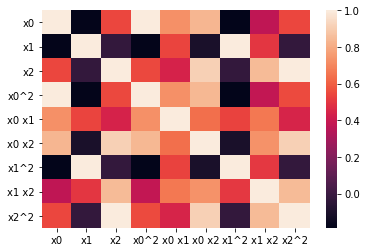

In [43]:
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [44]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

X_poly = poly.fit_transform(X)
X_poly.shape

(162501, 6)

In [45]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0 x1,x0 x2,x1 x2
0,1502.0,2215.0,2153.0,3326930.0,3233806.0,4768895.0
1,1667.0,2072.0,2047.0,3454024.0,3412349.0,4241384.0
2,1611.0,1957.0,1906.0,3152727.0,3070566.0,3730042.0
3,1601.0,1939.0,1831.0,3104339.0,2931431.0,3550309.0
4,1643.0,1965.0,1879.0,3228495.0,3087197.0,3692235.0


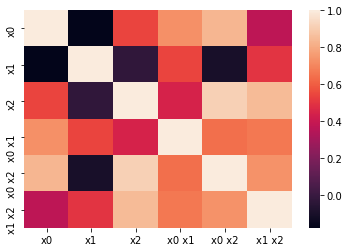

In [46]:
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [47]:
# 用新的多项式特征对KNN模型进行网格搜索，在流水线中进行。
# （1）先设置流水线参数：
pipe_params = {'poly_features__degree': [1, 2, 3], 'poly_features__interaction_only': [True, False], 'classify__n_neighbors': [3, 4, 5, 6]}

# (2) 然后实例化流水线：
from sklearn.pipeline import Pipeline

pipe = Pipeline([('poly_features', poly), ('classify', knn)])

# (3) 最后设置网格搜索，打印最佳准确率和学习到的参数：
grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

D:\Users\liulu03\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.7211894080651812 {'classify__n_neighbors': 5, 'poly_features__degree': 2, 'poly_features__interaction_only': True}
